In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
hitting_df = pd.read_csv(PATH_TO_OUTPUT_DATA + 'COV_AGGREGATE.csv')
game_df = pd.read_csv(PATH_TO_OUTPUT_DATA + 'GAME_LEVEL.csv')

def convert_team_ids(team):
    if (team == 'LAA'):
        return 'ANA' # matches up with previous table
    if (team == 'FLO'):
        return 'MIA' # matches up with previous table
    if (team == 'MON'):
        return 'WAS' # matches up with previous table
    return team

hitting_df['team'] = hitting_df['team'].apply(convert_team_ids)
batting_df_test = hitting_df.copy()

In [36]:
pitching_df = pd.read_csv(PATH_TO_DATA + 'pitchers/Pitching.csv')
players_df = pd.read_csv(PATH_TO_DATA + 'pitchers/People.csv')[['playerID', 'retroID', 'bbrefID']]

In [37]:
pitching_df = pitching_df[pitching_df.yearID >= 1999] # don't need earlier data

def convert_team_ids(team):
    if (team == 'LAA'):
        return 'ANA' # matches up with previous table
    if (team == 'FLO'):
        return 'MIA' # matches up with previous table
    if (team == 'MON'):
        return 'WAS' # matches up with previous table
    return team

pitching_df.teamID = pitching_df.teamID.apply(convert_team_ids)

Brief examine to consider starting pitcher stats

In [38]:
starters_df = []
for i in [8, 10, 12, 15, 20, 25]:
    if (len(starters_df) == 0):
        starters_df = pitching_df[pitching_df.GS > i].groupby('yearID')['playerID'].count().rename(i).to_frame()
    else:
        starters_df = pd.concat([starters_df,
            pitching_df[pitching_df.GS > i].groupby('yearID')['playerID'].count().rename(i).to_frame()], axis = 1)

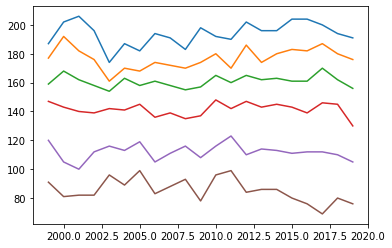

In [39]:
# Set starter = 12 starts per year
plt.plot(starters_df)

In [40]:
# starting pitchers
starters_df = pitching_df[pitching_df.GS > 12] # starting pitchers

In [41]:
starters_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
32263,abbotji01,1999,1,MIL,NL,2,8,20,15,0,...,3.0,7,2.0,0,394.0,3,71,2.0,1.0,9.0
32276,alvarwi01,1999,1,TBA,AL,9,9,28,28,1,...,1.0,3,6.0,0,703.0,0,92,3.0,3.0,25.0
32277,anderbr02,1999,1,ARI,NL,8,2,31,19,2,...,3.0,0,1.0,2,549.0,4,69,4.0,0.0,10.0
32281,appieke01,1999,1,KCA,AL,9,9,22,22,1,...,3.0,5,6.0,0,613.0,0,81,5.0,3.0,14.0
32285,arrojro01,1999,1,TBA,AL,7,12,24,24,2,...,2.0,2,14.0,0,630.0,0,84,5.0,3.0,15.0


In [42]:
players_df.head()

,playerID,retroID,bbrefID
0,aardsda01,aardd001,aardsda01
1,aaronha01,aaroh101,aaronha01
2,aaronto01,aarot101,aaronto01
3,aasedo01,aased001,aasedo01
4,abadan01,abada001,abadan01


In [43]:
print(starters_df.columns)
starters_df['WHIP'] = (starters_df['H'] + starters_df['BB'] + starters_df['HBP'] )/starters_df['IPouts']*3
starters_df['IP_Start'] = (starters_df['IPouts'])/starters_df['GS']/3
starters_df['HR9'] = (starters_df['HR'])/starters_df['IPouts']*27
starters_df['K9'] = (starters_df['SO'])/starters_df['IPouts']*27
starters_df['K/BB'] = (starters_df['SO'])/starters_df['BB']

starters_df['FIP_NORM'] = 3*(13*starters_df['HR'] + 
                           3*starters_df['BB'] +
                           3*starters_df['HBP'] - 
                            2*starters_df['SO'])/starters_df['IPouts']

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')


<ipython-input-43-7a3396b07892>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starters_df['WHIP'] = (starters_df['H'] + starters_df['BB'] + starters_df['HBP'] )/starters_df['IPouts']*3
<ipython-input-43-7a3396b07892>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starters_df['IP_Start'] = (starters_df['IPouts'])/starters_df['GS']/3
<ipython-input-43-7a3396b07892>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [44]:
ERA_CHECKS = starters_df.groupby(
    'yearID')[[
    'ERA', 'FIP_NORM']].mean()

ERA_CHECKS['FIP_ADD'] = ERA_CHECKS['ERA'] - \
                ERA_CHECKS['FIP_NORM']

In [45]:
ERA_CHECKS.loc[2001, 'FIP_ADD']

3.128030525478708

In [46]:
starters_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,R,SH,SF,GIDP,WHIP,IP_Start,HR9,K9,K/BB,FIP_NORM
32263,abbotji01,1999,1,MIL,NL,2,8,20,15,0,...,71,2.0,1.0,9.0,1.878049,5.466667,1.536585,4.060976,0.880952,2.926829
32276,alvarwi01,1999,1,TBA,AL,9,9,28,28,1,...,92,3.0,3.0,25.0,1.525000,5.714286,1.237500,7.200000,1.620253,1.781250
32277,anderbr02,1999,1,ARI,NL,8,2,31,19,2,...,69,4.0,0.0,10.0,1.330769,6.842105,1.246154,5.192308,2.678571,1.315385
32281,appieke01,1999,1,KCA,AL,9,9,22,22,1,...,81,5.0,3.0,14.0,1.496437,6.378788,1.154394,5.002375,1.529412,1.774347
32285,arrojro01,1999,1,TBA,AL,7,12,24,24,2,...,84,5.0,3.0,15.0,1.677725,5.861111,1.471564,6.845972,1.783333,2.182464


In [47]:
starters_df['FIP'] = 0

<ipython-input-47-d6600ebd77bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starters_df['FIP'] = 0


In [48]:
def compute_FIP(x):
    x['FIP'] = x['FIP_NORM'] + ERA_CHECKS.loc[x.yearID, 'FIP_ADD']
    return x
starters2 = starters_df.apply(compute_FIP, axis = 1)

In [49]:
starters2[starters2.FIP < 2]

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,SH,SF,GIDP,WHIP,IP_Start,HR9,K9,K/BB,FIP_NORM,FIP
32581,martipe02,1999,1,BOS,AL,23,4,31,29,5,...,3.0,6.0,11.0,0.965625,7.356322,0.379688,13.204688,8.459459,-1.739062,1.443070
33910,martipe02,2001,1,BOS,AL,7,3,18,18,1,...,2.0,0.0,5.0,0.985714,6.481481,0.385714,12.574286,6.520000,-1.440000,1.688031
42939,kershcl01,2014,1,LAN,NL,21,3,27,27,6,...,6.0,1.0,15.0,0.867227,7.345679,0.408403,10.845378,7.709677,-1.321008,1.762619
44524,kershcl01,2016,1,LAN,NL,12,4,21,21,3,...,4.0,1.0,9.0,0.738255,7.095238,0.483221,10.389262,15.636364,-1.348993,1.834959
45995,degroja01,2018,1,NYN,NL,10,9,32,32,1,...,3.0,5.0,13.0,0.935484,6.781250,0.414747,11.156682,5.847826,-1.175115,1.903913
46518,salech01,2018,1,BOS,AL,12,4,27,27,0,...,0.0,4.0,4.0,0.949367,5.851852,0.626582,13.500000,6.970588,-1.183544,1.895484


In [50]:
PITCHERS = starters2.merge(players_df)[['retroID', 'yearID', 'teamID', 
                               'W', 'L', 'G', 'GS', 'IPouts', 'IP_Start',
                               'SO', 'BAOpp', 'ERA', 'FIP', 'WHIP', 'K9', 'HR9', 'K/BB']].rename({
    'yearID': 'Y',
    'teamID': 'team',
    'IPouts': 'IP',
    'BAOpp': 'BAA'
}, axis = 1)
PITCHERS['IP'] = PITCHERS['IP']/3

In [51]:
PITCHERS.columns

Index(['retroID', 'Y', 'team', 'W', 'L', 'G', 'GS', 'IP', 'IP_Start', 'SO',
       'BAA', 'ERA', 'FIP', 'WHIP', 'K9', 'HR9', 'K/BB'],
      dtype='object')

In [52]:
PITCHERS.to_csv(PATH_TO_OUTPUT_DATA + 'STARTING_PITCHERS_v3.csv', index = False)

### Computing covariate priors

Determining each new season as the prior from the previous season

In [193]:
batting_df_test

,team,date,AB,RS,H,HR,TB,BB,SF
0,ANA,20000403,35,2,10,1,14,5,0
1,ANA,20000404,36,3,10,0,10,6,0
2,ANA,20000405,33,12,12,1,19,9,2
3,ANA,20000407,32,7,9,2,17,5,0
4,ANA,20000408,35,7,13,1,20,1,0
...,...,...,...,...,...,...,...,...,...
96140,WAS,20190925,33,3,8,2,15,1,0
96141,WAS,20190926,34,5,9,2,18,7,0
96142,WAS,20190927,34,6,11,2,20,4,0
96143,WAS,20190928,34,7,11,1,17,6,0


In [255]:
batting_df_test.reset_index(drop = True, inplace = True)
batting_df_test = batting_df_test.set_index('team')
batting_df_test['Y'] = batting_df_test.date.apply(lambda x: round(x/10000))
grouped_batting = batting_df_test.groupby(['team', 'Y']).sum()
avgs = grouped_batting['H']/grouped_batting['AB']

avg_reset = avgs.reset_index(level = 1).rename({0: 'VALUE'}, axis = 1)
avg_reset.head()

,Y,VALUE
team,,
ANA,2000,0.277406
ANA,2001,0.258070
ANA,2002,0.279707
ANA,2003,0.263318
ANA,2004,0.276666


In [256]:
def create_prior_variables(avg_reset):
    TABLE = pd.DataFrame(columns = ['Y'] + sorted(list(set(batting_df_test.index))))

    avg_year = {}
    for year in range(2001, 2020):
        avg_year['Y'] = year
        for team in sorted(list(set(batting_df_test.index))):
            # Find PREVIOUS YEAR
            avg_year[team] = avg_reset[avg_reset.Y == (year - 1)].loc[team, 'VALUE']
        TABLE = pd.concat([TABLE, pd.DataFrame(avg_year, index = [0])])

    return TABLE.set_index('Y')

TEAM_BATTING_AVG = create_prior_variables(avg_reset)


obp = ((grouped_batting['H'] + grouped_batting['BB'])/(
    grouped_batting['AB'] + grouped_batting['BB'] + grouped_batting['SF'])).reset_index(
    level = 1).rename({0: 'VALUE'}, axis = 1)
TEAM_BATTING_OBP = create_prior_variables(obp)

slg = ((grouped_batting['TB'])/(
    grouped_batting['AB'])).reset_index(
    level = 1).rename({0: 'VALUE'}, axis = 1)
TEAM_BATTING_SLG = create_prior_variables(slg)

In [257]:
TEAM_BATTING_AVG.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_AVG_PRIORS.csv')
TEAM_BATTING_OBP.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_OBP_PRIORS.csv')
TEAM_BATTING_SLG.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_SLG_PRIORS.csv')

### Computing input covariates

In [399]:
TEAM_BATTING_AVG = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_AVG_PRIORS.csv').set_index('Y')
TEAM_BATTING_OBP = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_OBP_PRIORS.csv').set_index('Y')
TEAM_BATTING_SLG = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_SLG_PRIORS.csv').set_index('Y')

In [400]:
TEAM_BATTING_AVG.head()

,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
Y,,,,,,,,,,,,,,,,,,,,,
2001,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
2002,0.258070,0.264988,0.258724,0.245706,0.264248,0.264318,0.258674,0.259122,0.275783,0.288365,...,0.257843,0.244632,0.249187,0.285490,0.264248,0.267201,0.255743,0.273219,0.260140,0.250414
2003,0.279707,0.264542,0.258134,0.243740,0.273876,0.265538,0.243687,0.250724,0.246753,0.270931,...,0.256148,0.242080,0.250404,0.271839,0.264584,0.265622,0.250442,0.267493,0.258937,0.258858
2004,0.263318,0.258913,0.278586,0.262556,0.285788,0.259472,0.253633,0.239184,0.248987,0.261782,...,0.256783,0.261250,0.256087,0.267471,0.258621,0.272273,0.261043,0.262781,0.276678,0.253155
2005,0.276666,0.248669,0.265360,0.275726,0.278680,0.262775,0.262170,0.245902,0.268531,0.267517,...,0.261975,0.254821,0.268349,0.264746,0.264001,0.271783,0.253536,0.262537,0.256740,0.242732


In [401]:
AVG_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')
OBP_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')
SLG_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')

In [402]:
dates = sorted(list(set(batting_df_test[batting_df_test.Y >= 2001]['date'])))
for i in range(len(dates)):
    AVG_COV_DF.loc[dates[i]] = 0
    OBP_COV_DF.loc[dates[i]] = 0
    SLG_COV_DF.loc[dates[i]] = 0

In [403]:
import time

In [404]:
start = time.time()
for year in range(2001, 2020):
    year_start = time.time()
    INPUT_DATA = batting_df_test[batting_df_test.Y == year]
    dates = sorted(list(set(INPUT_DATA['date']))) # dates for each year

    for team in sorted(list(set(INPUT_DATA.index))):
        prior_avg = TEAM_BATTING_AVG.loc[year, team]
        prior_obp = TEAM_BATTING_OBP.loc[year, team]
        prior_slg = TEAM_BATTING_SLG.loc[year, team]

        # finds data only for that specific team
        ROLLING_DATA = INPUT_DATA.loc[team].set_index('date').rolling(7).sum()
        ROLLING_DATA['AVG'] = ROLLING_DATA['H']/ROLLING_DATA['AB']
        ROLLING_DATA['OBP'] = (ROLLING_DATA['H'] + ROLLING_DATA['BB'])/(
            ROLLING_DATA['AB'] + ROLLING_DATA['BB'] + ROLLING_DATA['SF'])
        ROLLING_DATA['SLG'] = ROLLING_DATA['TB']/ROLLING_DATA['AB']

        # iterates over all dfs
        for i in range(len(dates)):
            if (i < 7):
                # set first 7 days to be the last year's average
                AVG_COV_DF.loc[dates[i]][team] = prior_avg
                OBP_COV_DF.loc[dates[i]][team] = prior_obp
                SLG_COV_DF.loc[dates[i]][team] = prior_slg
            else:
                # try setting to rolling average or previous day
                try:
                    if (ROLLING_DATA.loc[dates[i]]['AVG'] != ROLLING_DATA.loc[dates[i]]['AVG']):
                        # replace nulls
                        AVG_COV_DF.loc[dates[i]][team] = prior_avg
                        OBP_COV_DF.loc[dates[i]][team] = prior_obp
                        SLG_COV_DF.loc[dates[i]][team] = prior_slg
                    else:
                        AVG_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['AVG']
                        OBP_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['OBP']
                        SLG_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['SLG']

                        prior_avg = ROLLING_DATA.loc[dates[i]]['AVG']
                        prior_obp = ROLLING_DATA.loc[dates[i]]['OBP']
                        prior_slg = ROLLING_DATA.loc[dates[i]]['SLG']
                except:
                    # set the prior avg
                    AVG_COV_DF.loc[dates[i]][team] = prior_avg
                    OBP_COV_DF.loc[dates[i]][team] = prior_obp
                    SLG_COV_DF.loc[dates[i]][team] = prior_slg
    year_end = time.time()
    print('year ' + str(year) + ' took: ' + str(round((year_end - year_start)*1000)/1000))

year 2001 took: 5.669
year 2002 took: 6.151
year 2003 took: 5.695
year 2004 took: 5.653
year 2005 took: 5.962
year 2006 took: 5.998
year 2007 took: 5.513
year 2008 took: 5.48
year 2009 took: 5.468
year 2010 took: 6.424
year 2011 took: 5.703
year 2012 took: 5.42
year 2013 took: 5.994
year 2014 took: 5.413
year 2015 took: 5.599
year 2016 took: 5.913
year 2017 took: 5.809
year 2018 took: 5.99
year 2019 took: 5.819


In [405]:
# EXPORT
AVG_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_AVG.csv')
OBP_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_OBP.csv')
SLG_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_SLG.csv')

### Why we use covariate AVGs and rolling #'s
Now we want to combine pitcher data with our game-levels
Note that we only included the rolling stats because individual game-to-game predictions have too much variance

Rollign #'s hits don't mean anything...

0.10146878451798538
0.10367851373738675


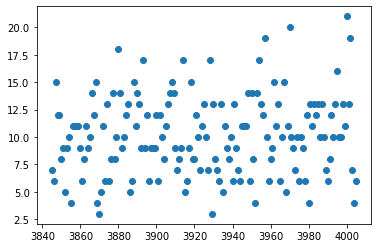

In [406]:
# see variance of Mariners in 2001
check_df = batting_df_test[batting_df_test.Y == 2001].reset_index()
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].H)
print(np.corrcoef(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].H)[0][1])
print(np.corrcoef(check_df[check_df.team == 'SEA'].date, check_df[check_df.team == 'SEA'].H)[0][1])

0.10317275979347197


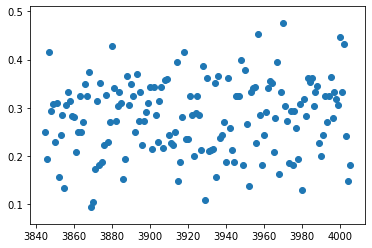

In [407]:
plt.scatter(check_df[check_df.team == 'SEA'].index, 
            check_df[check_df.team == 'SEA'].H/check_df[check_df.team == 'SEA'].AB)
print(np.corrcoef(check_df[check_df.team == 'SEA'].index, 
                  check_df[check_df.team == 'SEA'].H/check_df[check_df.team == 'SEA'].AB)[0][1])

0.06780499642699063

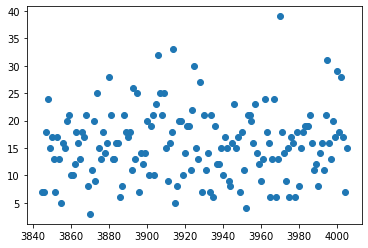

In [408]:
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)
import numpy as np
np.corrcoef(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)[0][1]

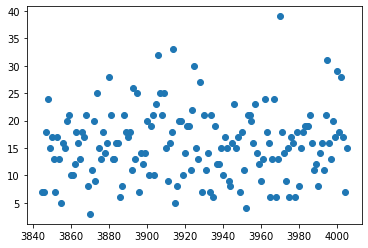

In [409]:
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)

0.3911805582664684


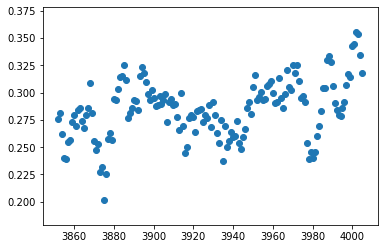

In [410]:
# However when we use a 7 day we get up to .39 R
plt.scatter(check_df[check_df.team == 'SEA'].index[7:], 
            (check_df[check_df.team == 'SEA'].H.rolling(7).sum()/check_df[
                      check_df.team == 'SEA'].AB.rolling(7).sum()).reset_index(drop = True)[7:])
print(np.corrcoef(check_df[check_df.team == 'SEA'].index[7:], 
                  (check_df[check_df.team == 'SEA'].H.rolling(7).sum()/check_df[
                      check_df.team == 'SEA'].AB.rolling(7).sum()).reset_index(drop = True)[7:])[0][1])

-0.040580986310728484


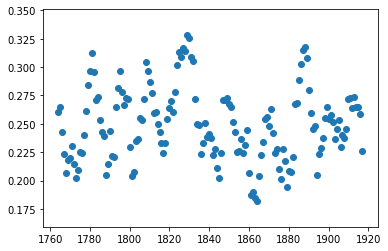

In [411]:
# Not always right...
check_df = batting_df_test[batting_df_test.Y == 2018].reset_index()
plt.scatter(check_df[check_df.team == 'HOU'].index[7:], 
            (check_df[check_df.team == 'HOU'].H.rolling(7).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(7).sum()).reset_index(drop = True)[7:])
print(np.corrcoef(check_df[check_df.team == 'HOU'].index[7:], 
                  (check_df[check_df.team == 'HOU'].H.rolling(7).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(7).sum()).reset_index(drop = True)[7:])[0][1])

-0.052403969183252776


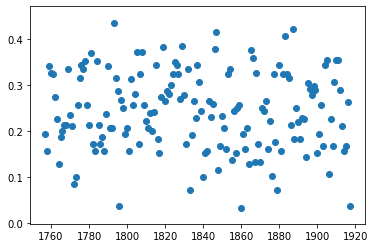

In [412]:
# Not always right...
check_df = batting_df_test[batting_df_test.Y == 2018].reset_index()
plt.scatter(check_df[check_df.team == 'HOU'].index[0:], 
            (check_df[check_df.team == 'HOU'].H.rolling(1).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(1).sum()).reset_index(drop = True)[0:])
print(np.corrcoef(check_df[check_df.team == 'HOU'].index[0:], 
                  (check_df[check_df.team == 'HOU'].H.rolling(1).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(1).sum()).reset_index(drop = True)[0:])[0][1])

In [414]:
check_df.head()

,team,date,AB,RS,H,HR,TB,BB,SF,Y
0,ANA,20180329,46,4,13,3,26,1,0,2018
1,ANA,20180330,32,2,6,1,9,0,0,2018
2,ANA,20180331,41,7,12,0,20,2,0,2018
3,ANA,20180401,38,6,13,0,17,2,0,2018
4,ANA,20180402,34,0,6,0,7,4,0,2018


### Integrating pitchers
Time to integrate pitchers??

In [4]:
AVG_COV_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_AVG.csv').set_index('date')
OBP_COV_DF= pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_OBP.csv').set_index('date')
SLG_COV_DF= pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_SLG.csv').set_index('date')
PITCHERS= pd.read_csv(PATH_TO_OUTPUT_DATA + 'STARTING_PITCHERS_v3.csv')

In [53]:
PITCHERS= pd.read_csv(PATH_TO_OUTPUT_DATA + 'STARTING_PITCHERS_v3.csv')
PITCHERS.head()

,retroID,Y,team,W,L,G,GS,IP,IP_Start,SO,BAA,ERA,FIP,WHIP,K9,HR9,K/BB
0,abboj001,1999,MIL,2,8,20,15,82.000000,5.466667,37,0.317,6.91,6.108962,1.878049,4.060976,1.536585,0.880952
1,alvaw001,1999,TBA,9,9,28,28,160.000000,5.714286,128,0.260,4.22,4.963382,1.525000,7.200000,1.237500,1.620253
2,alvaw001,2004,LAN,7,6,40,15,120.666667,8.044444,102,0.244,4.03,3.525545,1.201657,7.607735,0.895028,3.290323
3,andeb002,1999,ARI,8,2,31,19,130.000000,6.842105,75,0.279,4.57,4.497517,1.330769,5.192308,1.246154,2.678571
4,andeb002,2000,ARI,11,7,33,32,213.333333,6.666667,104,0.275,4.05,5.098933,1.256250,4.387500,1.603125,2.666667


In [54]:
AVG_COV_DF

,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
date,,,,,,,,,,,,,,,,,,,,,
20010401,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010402,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010403,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010404,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010405,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190925,0.244813,0.228571,0.238298,0.236364,0.261029,0.333333,0.219008,0.216667,0.248963,0.232210,...,0.211111,0.214876,0.185345,0.190476,0.214815,0.231579,0.250000,0.238298,0.221344,0.258303
20190926,0.225806,0.228571,0.238298,0.236364,0.261029,0.327138,0.227273,0.223140,0.235043,0.234432,...,0.200000,0.248000,0.165939,0.180723,0.211538,0.231579,0.250000,0.242553,0.221344,0.259259
20190927,0.220408,0.219424,0.252101,0.230769,0.266160,0.327138,0.242798,0.214286,0.200873,0.237918,...,0.199301,0.252066,0.173160,0.168067,0.212928,0.226148,0.243028,0.253112,0.200803,0.273063


In [7]:
drop_labels = ['home_' + str(x) + '_id' for x in range(1, 10)] + ['away_' + str(x) + '_id' for x in range(1, 10)]

game_df_new = game_df.drop(columns = drop_labels, axis = 1)

In [8]:
game_df_new['home_AVG'] = 0
game_df_new['home_OBP'] = 0
game_df_new['home_SLG'] = 0

game_df_new['away_AVG'] = 0
game_df_new['away_OBP'] = 0
game_df_new['away_SLG'] = 0

In [9]:
# format date column
game_df_new['date'] = game_df_new.dt.apply(lambda x: int(x.split('-')[0] + x.split('-')[1] + x.split('-')[2]))

In [10]:
def get_covariates(x):
    x['home_AVG'] = AVG_COV_DF.loc[x['date']][x['home_team']]
    x['away_AVG'] = AVG_COV_DF.loc[x['date']][x['away_team']]
    x['home_OBP'] = OBP_COV_DF.loc[x['date']][x['home_team']]
    x['away_OBP'] = OBP_COV_DF.loc[x['date']][x['away_team']]
    x['home_SLG'] = SLG_COV_DF.loc[x['date']][x['home_team']]
    x['away_SLG'] = SLG_COV_DF.loc[x['date']][x['away_team']]
    return(x)
post_2001_games = game_df_new[game_df_new.Y >= 2001].apply(get_covariates, axis = 1)

In [11]:
post_2001_games.head()

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,home_OBP,home_SLG,away_AVG,away_OBP,away_SLG,date
2428,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,0.339283,0.466387,0.281519,0.349386,0.443116,20010401
2429,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,0.357486,0.448264,0.267825,0.353322,0.450778,20010402
2430,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,0.359380,0.468525,0.251828,0.327088,0.398252,20010402
2431,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,0.336984,0.426431,0.243537,0.322708,0.400071,20010402
2432,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,0.341041,0.443798,0.268227,0.342770,0.423582,20010402


In [12]:
# > 0 = home is better
post_2001_games['AVG_difference'] = (post_2001_games['home_AVG'] - post_2001_games['away_AVG'])*1000
post_2001_games['OBP_difference'] = (post_2001_games['home_OBP'] - post_2001_games['away_OBP'])*1000
post_2001_games['SLG_difference'] = (post_2001_games['home_SLG'] - post_2001_games['away_SLG'])*1000

# scaling doesn't matter for many cases
post_2001_games['AVG_difference_PCT'] = (post_2001_games['home_AVG'] - post_2001_games['away_AVG'])/(
    post_2001_games['home_AVG']
)*100
post_2001_games['OBP_difference_PCT'] = (post_2001_games['home_OBP'] - post_2001_games['away_OBP'])/(
    post_2001_games['home_OBP']
)*100
post_2001_games['SLG_difference_PCT'] = (post_2001_games['home_SLG'] - post_2001_games['away_SLG'])/(
    post_2001_games['home_SLG']
)*100

In [13]:
post_2001_games

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,away_AVG,away_OBP,away_SLG,date,AVG_difference,OBP_difference,SLG_difference,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT
2428,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,0.281519,0.349386,0.443116,20010401,-8.059871,-10.103320,23.270676,-2.947374,-2.977845,4.989568
2429,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,0.267825,0.353322,0.450778,20010402,22.351406,4.164662,-2.514311,7.702701,1.164985,-0.560900
2430,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,0.251828,0.327088,0.398252,20010402,24.251065,32.291929,70.272995,8.784099,8.985458,14.998766
2431,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,0.243537,0.322708,0.400071,20010402,10.660336,14.276221,26.359450,4.193722,4.236467,6.181414
2432,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,0.268227,0.342770,0.423582,20010402,3.971909,-1.728942,20.216091,1.459194,-0.506960,4.555242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48551,2019-09-29,2019,9,29,ATL,NYN,sorom001,syndn001,1,0.256098,...,0.237903,0.325000,0.395161,20190929,18.194335,11.956522,47.928141,7.104455,3.548387,10.816810
48552,2019-09-29,2019,9,29,MIL,COL,housa001,hoffj003,1,0.230496,...,0.233202,0.331034,0.430830,20190929,-2.705127,-24.325218,-8.844224,-1.173609,-7.931034,-2.095858
48553,2019-09-29,2019,9,29,SDN,ARI,baezm001,walkt004,1,0.218868,...,0.210970,0.280769,0.354430,20190929,7.897460,36.062452,19.154526,3.608322,11.382212,5.127222
48554,2019-09-29,2019,9,29,HOU,ANA,coleg001,peted001,0,0.196653,...,0.245059,0.345890,0.501976,20190929,-48.406569,-78.714838,-167.248251,-24.615255,-29.461840,-49.965415


In [14]:
post_2001_games = post_2001_games.reset_index(drop = True)

In [15]:
post_2001_games.head()

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,away_AVG,away_OBP,away_SLG,date,AVG_difference,OBP_difference,SLG_difference,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,0.281519,0.349386,0.443116,20010401,-8.059871,-10.103320,23.270676,-2.947374,-2.977845,4.989568
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,0.267825,0.353322,0.450778,20010402,22.351406,4.164662,-2.514311,7.702701,1.164985,-0.560900
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,0.251828,0.327088,0.398252,20010402,24.251065,32.291929,70.272995,8.784099,8.985458,14.998766
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,0.243537,0.322708,0.400071,20010402,10.660336,14.276221,26.359450,4.193722,4.236467,6.181414
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,0.268227,0.342770,0.423582,20010402,3.971909,-1.728942,20.216091,1.459194,-0.506960,4.555242


In [16]:
post_2001_games

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,away_AVG,away_OBP,away_SLG,date,AVG_difference,OBP_difference,SLG_difference,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,0.281519,0.349386,0.443116,20010401,-8.059871,-10.103320,23.270676,-2.947374,-2.977845,4.989568
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,0.267825,0.353322,0.450778,20010402,22.351406,4.164662,-2.514311,7.702701,1.164985,-0.560900
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,0.251828,0.327088,0.398252,20010402,24.251065,32.291929,70.272995,8.784099,8.985458,14.998766
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,0.243537,0.322708,0.400071,20010402,10.660336,14.276221,26.359450,4.193722,4.236467,6.181414
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,0.268227,0.342770,0.423582,20010402,3.971909,-1.728942,20.216091,1.459194,-0.506960,4.555242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,2019-09-29,2019,9,29,ATL,NYN,sorom001,syndn001,1,0.256098,...,0.237903,0.325000,0.395161,20190929,18.194335,11.956522,47.928141,7.104455,3.548387,10.816810
46124,2019-09-29,2019,9,29,MIL,COL,housa001,hoffj003,1,0.230496,...,0.233202,0.331034,0.430830,20190929,-2.705127,-24.325218,-8.844224,-1.173609,-7.931034,-2.095858
46125,2019-09-29,2019,9,29,SDN,ARI,baezm001,walkt004,1,0.218868,...,0.210970,0.280769,0.354430,20190929,7.897460,36.062452,19.154526,3.608322,11.382212,5.127222
46126,2019-09-29,2019,9,29,HOU,ANA,coleg001,peted001,0,0.196653,...,0.245059,0.345890,0.501976,20190929,-48.406569,-78.714838,-167.248251,-24.615255,-29.461840,-49.965415


In [64]:
def lookup_stats(Y, retroID):
    return PITCHERS[(PITCHERS.retroID == retroID) & (PITCHERS.Y == (Y - 1))
                   ].reset_index(drop = True)

In [65]:
for col in ['IP_Start', 'ERA', 'WHIP', 'BAA', 'K9', 'HR9', 'K/BB']:
    post_2001_games['home_p_' + col] = 0
    post_2001_games['away_p_' + col] = 0
    post_2001_games[col + '_difference'] = 0
    post_2001_games[col + '_difference_PCT'] = 0

In [66]:
post_2001_games['missing_data'] = 0 # missing flag

In [67]:
# Rip, some are missing
'hentp001' in PITCHERS.retroID

False

In [68]:
PITCHERS[(PITCHERS.Y == post_2001_games.loc[0, 'Y'])].mean() # give them avg performance

Y           2001.000000
W              9.641975
L              8.845679
G             28.160494
GS            24.901235
IP           156.835391
IP_Start       6.296783
SO           112.364198
BAA            0.268895
ERA            4.577222
FIP            4.577222
WHIP           1.428500
K9             6.344600
HR9            1.175797
K/BB           2.270968
dtype: float64

In [69]:
# REALLY SLOW PIECE OF CODE
import time 
start_time = time.time()
for i in range(len(post_2001_games)):
    if (i % 4000 == 0):
        year_end = time.time()
        print('first ' + str(i) + ' total: ' + str(round((year_end - start_time)*1000)/1000))
    for col in ['IP_Start', 'ERA', 'FIP', 'WHIP', 'BAA', 'K9', 'HR9', 'K/BB']:
        home_pitcher = lookup_stats(post_2001_games.loc[i, 'Y'], post_2001_games.loc[i, 'home_pitcher_id'])
        away_pitcher = lookup_stats(post_2001_games.loc[i, 'Y'], post_2001_games.loc[i, 'away_pitcher_id'])
        
        try:
            post_2001_games.loc[i, 'home_p_' + col] = home_pitcher.loc[0, col]
        except KeyError:
            post_2001_games.loc[i, 'home_p_' + col] = PITCHERS[
                (PITCHERS.Y == post_2001_games.loc[i, 'Y'])].mean()[col]
            post_2001_games.loc[i, 'missing_data'] = 1
        try:
            post_2001_games.loc[i, 'away_p_' + col] = away_pitcher.loc[0, col]
        except KeyError:
            post_2001_games.loc[i, 'away_p_' + col] = PITCHERS[
                (PITCHERS.Y == post_2001_games.loc[i, 'Y'])].mean()[col]
            post_2001_games.loc[i, 'missing_data'] = 1

first 0 total: 0.0
first 4000 total: 294.094
first 8000 total: 599.853
first 12000 total: 871.563
first 16000 total: 1149.348
first 20000 total: 1467.801
first 24000 total: 1833.027
first 28000 total: 2202.419
first 32000 total: 2578.326
first 36000 total: 2868.212
first 40000 total: 3217.467
first 44000 total: 3560.904


In [70]:
post_2001_games

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,away_p_HR9,HR9_difference,HR9_difference_PCT,home_p_K/BB,away_p_K/BB,K/BB_difference,K/BB_difference_PCT,missing_data,home_p_FIP,away_p_FIP
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,1.202765,0,0,2.419355,1.474747,0,0,0,5.263956,5.052476
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,1.278336,0,0,1.525253,3.310345,0,0,0,3.852216,4.278157
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,1.232143,0,0,2.260274,2.055556,0,0,0,3.946850,4.643874
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,0.655870,0,0,1.750000,1.090909,0,0,0,4.260603,4.880234
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,0.870968,0,0,1.543478,2.156863,0,0,0,5.442492,4.016318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,2019-09-29,2019,9,29,ATL,NYN,sorom001,syndn001,1,0.256098,...,1.427206,0,0,3.974359,3.246986,0,0,1,2.722657,4.390192
46124,2019-09-29,2019,9,29,MIL,COL,housa001,hoffj003,1,0.230496,...,1.427206,0,0,3.246986,3.246986,0,0,1,4.390192,4.390192
46125,2019-09-29,2019,9,29,SDN,ARI,baezm001,walkt004,1,0.218868,...,1.427206,0,0,3.246986,3.246986,0,0,1,4.390192,4.390192
46126,2019-09-29,2019,9,29,HOU,ANA,coleg001,peted001,0,0.196653,...,0.853577,0,0,3.246986,4.312500,0,0,1,4.390192,2.619793


In [71]:
post_2001_games.to_csv('SAVE_TEMP_2001_v2.csv', index = False)

In [72]:
# apply PCT changes
for col in ['IP_Start', 'ERA', 'FIP', 'WHIP', 'BAA', 'K9', 'HR9', 'K/BB']:
    post_2001_games[col + '_difference'] = post_2001_games['home_p_' + col] - post_2001_games['away_p_' + col]
    post_2001_games[col + '_difference_PCT'] = (post_2001_games['home_p_' + col] - 
                                                post_2001_games['away_p_' + col])/(
       post_2001_games['home_p_' + col]
    )*100

In [73]:
post_2001_games

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,HR9_difference_PCT,home_p_K/BB,away_p_K/BB,K/BB_difference,K/BB_difference_PCT,missing_data,home_p_FIP,away_p_FIP,FIP_difference,FIP_difference_PCT
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,31.694828,2.419355,1.474747,0.944607,39.043771,0,5.263956,5.052476,0.211481,4.017523
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,-209.167862,1.525253,3.310345,-1.785092,-117.035853,0,3.852216,4.278157,-0.425941,-11.057026
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,-49.350649,2.260274,2.055556,0.204718,9.057239,0,3.946850,4.643874,-0.697024,-17.660257
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,21.573164,1.750000,1.090909,0.659091,37.662338,0,4.260603,4.880234,-0.619630,-14.543251
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,44.880785,1.543478,2.156863,-0.613384,-39.740403,0,5.442492,4.016318,1.426174,26.204427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,2019-09-29,2019,9,29,ATL,NYN,sorom001,syndn001,1,0.256098,...,-171.932580,3.974359,3.246986,0.727373,18.301632,1,2.722657,4.390192,-1.667536,-61.246644
46124,2019-09-29,2019,9,29,MIL,COL,housa001,hoffj003,1,0.230496,...,0.000000,3.246986,3.246986,0.000000,0.000000,1,4.390192,4.390192,0.000000,0.000000
46125,2019-09-29,2019,9,29,SDN,ARI,baezm001,walkt004,1,0.218868,...,0.000000,3.246986,3.246986,0.000000,0.000000,1,4.390192,4.390192,0.000000,0.000000
46126,2019-09-29,2019,9,29,HOU,ANA,coleg001,peted001,0,0.196653,...,40.192401,3.246986,4.312500,-1.065514,-32.815462,1,4.390192,2.619793,1.770399,40.326226


In [74]:
post_2001_games.to_csv(PATH_TO_OUTPUT_DATA + 'COVARIATE_DATA_PITCHER_BATTER_v3.csv', index = False)

### Retroactive adding in FIP
Because I forgot!

In [30]:
# post_2001_games_v2 = pd.read_csv(PATH_TO_OUTPUT_DATA + 'COVARIATE_DATA_PITCHER_BATTER_v3.csv')

In [ ]:
# def lookup_stats(Y, retroID):
#     return PITCHERS[(PITCHERS.retroID == retroID) & (PITCHERS.Y == Y)
#                    ].reset_index(drop = True)

In [ ]:
# # ADD IN FIP
# col = 'FIP'
# post_2001_games_v2['home_p_' + col] = 0
# post_2001_games_v2['away_p_' + col] = 0
# post_2001_games_v2[col + '_difference'] = 0
# post_2001_games_v2[col + '_difference_PCT'] = 0

# import time
# # REALLY SLOW PIECE OF CODE
# start_time = time.time()
# for i in range(len(post_2001_games_v2)):
#     if (i % 2000 == 500):
#         year_end = time.time()
#         print('first ' + str(i) + ' total: ' + str(round((year_end - start_time)*1000)/1000))
#     col = 'FIP'
#     home_pitcher = lookup_stats(post_2001_games_v2.loc[i, 'Y'], post_2001_games_v2.loc[i, 'home_pitcher_id'])
#     away_pitcher = lookup_stats(post_2001_games_v2.loc[i, 'Y'], post_2001_games_v2.loc[i, 'away_pitcher_id'])

#     try:
#         post_2001_games_v2.loc[i, 'home_p_' + col] = home_pitcher.loc[0, col]
#     except KeyError:
#         post_2001_games_v2.loc[i, 'home_p_' + col] = PITCHERS[
#             (PITCHERS.Y == post_2001_games_v2.loc[i, 'Y'])].mean()[col]
#         post_2001_games_v2.loc[i, 'missing_data'] = 1
#     try:
#         post_2001_games_v2.loc[i, 'away_p_' + col] = away_pitcher.loc[0, col]
#     except KeyError:
#         post_2001_games_v2.loc[i, 'away_p_' + col] = PITCHERS[
#             (PITCHERS.Y == post_2001_games_v2.loc[i, 'Y'])].mean()[col]
#         post_2001_games_v2.loc[i, 'missing_data'] = 1

In [ ]:
# # apply PCT changes
# col = 'FIP'    
# post_2001_games_v2[col + '_difference'] = post_2001_games_v2['home_p_' + col] - post_2001_games_v2['away_p_' + col]
# post_2001_games_v2[col + '_difference_PCT'] = (post_2001_games_v2['home_p_' + col] - 
#                                             post_2001_games_v2['away_p_' + col])/(
#    post_2001_games_v2['home_p_' + col]
# )*100

In [ ]:
# post_2001_games_v2.head(10)

In [ ]:
# post_2001_games_v2.to_csv(PATH_TO_OUTPUT_DATA + 'COVARIATE_DATA_PITCHER_BATTER_v4.csv', index = False)